### RQ3: Plot the temporal distribution of commit messages of random 1000 projects with at least 50,000 commits. Also, perform distribution fitting to finding the best distribution that fits the underlying commit messages at each repository level.

In [1]:
import pandas as pd
import chardet
import nltk
from nltk.corpus import stopwords
import pickle
import pyarrow.parquet as pq
import numpy
import os
import vaex as vx
import matplotlib.pyplot as plt
import seaborn as sns
import statistics as st
import math
import glob
from scipy.optimize import curve_fit
import time
import random 
from platform import python_version

In [2]:
%matplotlib inline

#### Using VAEX dataframes for larger 

In [3]:
# VAEX DATAFRAME
df= []

In [4]:
# READ ALL THE PARQUET FILE
df = vx.open('/data/fdac21/eawoc//processed_data/*.parquet')

In [5]:
# COLUMN NAMES
columns = ["projectID", "commitID", "author", "committer", 
           "authorTime", "committerTime", "authorTimezone", 
           "commitlsterTimezone", "commitMessage"]

In [6]:
# Review the data
df.head()

#,projectID,commitID,author,committer,authorTime,committerTime,authorTimezone,committerTimezone,commitMessage
0,wildfly_wildfly,00001a1a9d1552584eee5e62ab11d7b86408c0d8,ochaloup <ochaloup@redhat.com>,ochaloup <ochaloup@redhat.com>,1488898509,1489149067,+0100,+0100,'[JBTM-2858] adding JAXRS filter to import trans...
1,wildfly_wildfly,00010938ae7227834e2c69a9c3c71c95d3f3483d,Stuart Douglas <stuart.w.douglas@gmail.com>,Stuart Douglas <stuart.w.douglas@gmail.com>,1458105079,1458105079,+1100,+1100,WFCORE-1436 Undertow 1.3.19.Final
2,wildfly_wildfly,000183c08f9e7d9770ad8216acb565552da7bfb0,Jeff Mesnil <jmesnil@gmail.com>,Jeff Mesnil <jmesnil@gmail.com>,1332344580,1332436142,+0100,+0100,'[JBPAPP-8184] Connection factory failure\\n* add...
3,wildfly_wildfly,0001a3f7a195b75e563280609636faa249877036,jaikiran <jaikiran.pai@gmail.com>,baranowb <baranowb@gmail.com>,1328294482,1328611298,+0530,+0100,Upgrade to 2.0.0 of jboss-ejb3-ext-api
4,wildfly_wildfly,00024ccfa6fa6fd6426de7bb1d8d494798b384fe,James R. Perkins <jperkins@redhat.com>,GitHub <noreply@github.com>,1583899415,1583899415,-0700,-0700,'Merge pull request #13102 from kabir/WFLY-13222...
5,wildfly_wildfly,0002dbdc7b6cb98e6387cc5f0d11bb93229c5381,Kabir Khan <kkhan@redhat.com>,GitHub <noreply@github.com>,1491037874,1491037874,+0100,+0100,'Merge pull request #9883 from jbosstm/WFLY-8485...
6,wildfly_wildfly,000325d9bb03ceffbe9e7b4756a5566b273040d1,Brian Stansberry <brian.stansberry@redhat.com>,Brian Stansberry <brian.stansberry@redhat.com>,1503172204,1505862581,-0500,-0500,Minor cleanup
7,wildfly_wildfly,0003c4792f52061661cc9db421c7741bc4df8284,Richard Achmatowicz <rachmatowicz@jboss.com>,Paul Ferraro <paul.ferraro@redhat.com>,1370975878,1374591017,-0400,-0400,"[WFLY-1430] Add in XML processing, test cases."
8,wildfly_wildfly,0004ba7ca70b15a48fe6460ec5375c86cd8dc19d,Scott Marlow <smarlow@redhat.com>,Scott Marlow <smarlow@redhat.com>,1463689533,1473273893,-0400,-0400,'add org.wildfly.extension.nosql.common dependen...
9,wildfly_wildfly,000703aae4a2cc2cc0f1c4a9a03ae391bb76def0,Pelisse Romain <belaran@redhat.com>,GitHub <noreply@github.com>,1470623929,1470623929,+0000,+0000,'Merge 03a1e02b4aa392ec3d8914846eee615232f45d89 ...


In [7]:
# list of project names 
project_names = df.projectID.unique()
print(project_names)

['saqib-ali_hivemined', 'git.kernel.org_pub_scm/public-inbox/vger.kernel.org/linux-media/0', 'RIOT-OS_RIOT', 'trattkantarell_src', 'sahil28297_erpnext', 'ThePiGuy0_android_device_motorola_msm8226-common', 'git.kernel.org_pub_scm/public-inbox/vger.kernel.org/lkml/0', 'jdzs1_b', 'ZIDAN44_linux-stable', 'timhuynh94_231AS', 'Leaflet_Leaflet', 'discourse_discourse', 'gitorious.org_netbeans/main-silver', 'nanoframework_ChibiOS-bkp', 'AnnaLut_abs3', 'civicrm_civicrm-core', 'thomasNDS_lbl', 'gentoo_gentoo', 'neo4j_neo4j', 'maritimerabroad_gitfiti', 'dotnet_aspnetcore', 'geos4s_18S856162', 'learn-co-curriculum_python-for-loops-lab', 'jthub_ega-file-transfer-to-collab-1-jtracker', 'denis-gz_qtbase', 'Alsan_turing-chunk07', 'CRAZYFAKE_handiwork', 'i17c_ecode', 'Reese-D_my_emacs', 'gitlab.com_Ponce_slackbuilds', 'jthub_ega-file-transfer-to-collab-2-jtracker', 'stoupoun_p2-breathe', 'Waffiliate_repoForSynch', 'jthub_ega-file-transfer-to-collab-5-jtracker', 'Arshiamidos_84ck1N617', 'mono_mono', 'app

### [3] Plot the temporal distribution of commit messages of random 1000 projects with at least 50,000 commits. Also, perform distribution fitting to finding the best distribution that fits the underlying commit messages at each repository level. 

In [8]:
# Use the df data frame for the analysis from above. The commitMessage column contains all the 
# text of the projects. Recommended to work on a smaller sample of commitMessage first. 
# 1. from df select a random project and extract committerTime, sort in the increasing order. 
# Take the first 10k and the last 10k message for plotting. 

In [9]:
v = df.projectID.value_counts()

In [10]:
cans = df[df.projectID.isin(v.index[v.gt(50000)])]
cans = cans.projectID.unique()

In [11]:
random.seed(100)
projects = random.sample(cans, 1000)
print(projects)

['ruby_ruby', 'learn-co-students_activerecord-crud-v-000', 'keum_data_display', 'struan_netherlands', 'geovas01_man4', 'doctorjei_pidgin', 'gitlab.com_quicla_platform/tools/test/connectivity', 'chuan12_shenzhouzd', 'State-College-Plone_Products.IstTheme', 'llvm-project_llvm-project-ng', 'bioconda_bioconda-recipes', 'google-test_signcla-probe-repo', 'git.kernel.org_pub_scm/public-inbox/vger.kernel.org/lkml/5', 'pequet_public-logs', 'scriptzteam_newzNZB-Usenet-Upload-Logger-v1.1', 'apple_llvm-project-v5-split', 'Door43_d43-en', 'kanzure_brlcad', 'bahmedraaz_myProjectOpenAps', 'ARMmbed_DAPLink', 'Sarybe_ThumbnailTooltip', 'moiify_AutoGreen', '8irder_heartinternetstatus', 'flushbeer_waka', 'surli_backup-experiments', 'teku45_Web-DROP', 'infinit_elle', 'johame_w00t', 'ingenue_hunter-cache', 'git.eclipse.org_r_tracecompass/org.eclipse.tracecompass', 'project-draco-hr_liferay-portal', 'earl-ducaine_brl-cad-svn-follow', 'GregorStocks_0.1', 'acquia_blt', 'discourse_discourse', 'roschina_rosdoc_

In [12]:
from fitter import Fitter, get_common_distributions, get_distributions

,sumsquare_error,aic,bic,kl_div
cauchy,7.904308e-17,4368.139867,-7.500731e+06,0.203309
rayleigh,1.158239e-16,inf,-7.442261e+06,0.466524
norm,1.311430e-16,4314.180206,-7.423252e+06,0.312046
powerlaw,1.710880e-16,4123.408293,-7.382551e+06,0.834288
uniform,1.787594e-16,4121.230926,-7.375851e+06,0.902087


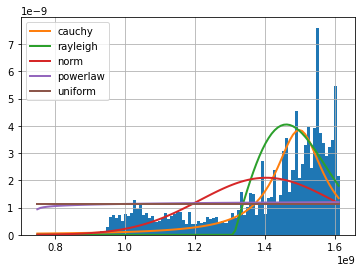

In [13]:
#example distribution
commits = df[df['projectID'] == 'devkitPro_newlib']['committerTime'].to_numpy().astype(int)
data = commits
f = Fitter(data,
           distributions= get_common_distributions())
f.fit()
f.summary()

In [14]:
f.get_best(method='sumsquare_error')

{'cauchy': {'loc': 1498617503.8003387, 'scale': 82670833.99347925}}

In [ ]:
dists = []
for project in projects:
    print(project)
    commits = df[df['projectID'] == project]\
                            ['committerTime'].to_numpy()
    commits = commits[commits != numpy.array(None)]
    commits = commits.astype(int)
    f = Fitter(commits,
           distributions= get_common_distributions(), timeout=120)
    f.fit()
    #f.summary()
    best = f.get_best(method='sumsquare_error')
    dists.append(best)
    print(best)

ruby_ruby
{'norm': {'loc': 1357944183.0969098, 'scale': 150970106.01606458}}
learn-co-students_activerecord-crud-v-000
{'rayleigh': {'loc': 1503045952.8364697, 'scale': 33059632.21134094}}
keum_data_display
{'powerlaw': {'a': 1.382209761887796, 'loc': 1395731931.1884315, 'scale': 123594388.15196946}}
struan_netherlands
{'powerlaw': {'a': 2.0630592835397863, 'loc': 1441783900.8565092, 'scale': 95739288.14350957}}
geovas01_man4
{'powerlaw': {'a': 0.26666864279136393, 'loc': -1.5318455998867464e-18, 'scale': 1761953656.5827894}}
doctorjei_pidgin
{'cauchy': {'loc': 1197764444.857496, 'scale': 71631828.47988464}}
gitlab.com_quicla_platform/tools/test/connectivity
{'rayleigh': {'loc': 1448823135.6753025, 'scale': 70543758.05180852}}
chuan12_shenzhouzd
{'exponpow': {'b': 0.8840325950059011, 'loc': 1523886659.9999995, 'scale': 54570957.73085578}}
State-College-Plone_Products.IstTheme
{'norm': {'loc': 1274416025.6351597, 'scale': 39141723.828055024}}
llvm-project_llvm-project-ng
{'powerlaw': {'

{'norm': {'loc': 1375835860.8278854, 'scale': 123103947.67120199}}
Door43_d43-en
{'gamma': {'a': 11.626481300498114, 'loc': 1383763502.7093096, 'scale': 5890024.881374162}}
kanzure_brlcad
{'powerlaw': {'a': 2.0629340508962946, 'loc': 341911410.78595746, 'scale': 1123362245.2140431}}
bahmedraaz_myProjectOpenAps
{'norm': {'loc': 1556699632.902388, 'scale': 4193246.5815624767}}
ARMmbed_DAPLink
{'norm': {'loc': 1519523247.1482966, 'scale': 50256037.94041998}}
Sarybe_ThumbnailTooltip
{'cauchy': {'loc': 1354562895.2862468, 'scale': 30016704.63499154}}
moiify_AutoGreen
{'gamma': {'a': 52954.24718899696, 'loc': -378416296.2789969, 'scale': 37367.97130367602}}
8irder_heartinternetstatus
{'cauchy': {'loc': 1376851425.5417626, 'scale': 5695204.585204914}}
flushbeer_waka
{'cauchy': {'loc': 1437538894.607642, 'scale': 3170.6220453245096}}
surli_backup-experiments
{'norm': {'loc': 1463838185.139818, 'scale': 92775629.43746024}}
teku45_Web-DROP
{'powerlaw': {'a': 1.1285917004331565, 'loc': 1469456792

{'uniform': {'loc': 1.0, 'scale': 2147483400.0}}
sourceconnect-tests_subscription
{'powerlaw': {'a': 1.5489077815005896, 'loc': 1511216726.5199952, 'scale': 71345969.48000479}}
alpinelinux_aports
{'powerlaw': {'a': 2.82067978129459, 'loc': 1135911628.6279573, 'scale': 479721171.37204885}}
usukhbayar-boop_PLS
{'gamma': {'a': 8.424547720566022, 'loc': 1426300727.5097737, 'scale': 13388968.830054749}}
spring-projects_spring-boot
{'cauchy': {'loc': 1531399343.1665769, 'scale': 44914764.28031714}}
MycroftAI_mycroft-core
{'cauchy': {'loc': 1519599871.5637546, 'scale': 402899.4043829852}}
makersacademy_airport_challenge
{'powerlaw': {'a': 1.1109977911987097, 'loc': 1416559817.1870732, 'scale': 198854364.8129273}}
majesty86_phase-0-tracks
{'gamma': {'a': 21.830758743009707, 'loc': 1418107468.8487701, 'scale': 2813360.288144259}}
licshire_public-buildpacks-ci-robots
{'norm': {'loc': 1543833851.8211966, 'scale': 30719284.08289429}}
Tiseg_github-slideshow
{'powerlaw': {'a': 2.479785634762961, 'lo

{'uniform': {'loc': 1604774628.0, 'scale': 7595949.0}}
cirosantilli_test-many-commits-1m


{'gamma': {'a': 0.1552564569945486, 'loc': -2.0794895717881375e-19, 'scale': 183806181.68569684}}
ngriffin7a_icefaces4-trunk
{'cauchy': {'loc': 1371088058.9918246, 'scale': 64151949.39982158}}
rust-lang_rust
{'powerlaw': {'a': 1.56442572385534, 'loc': 1272711362.1358778, 'scale': 342682403.8641228}}
SockPuppetry_Loop-A
{'powerlaw': {'a': 0.7793811257685694, 'loc': 1523706441.9999995, 'scale': 90476741.27844492}}
gspu_vbox
{'norm': {'loc': 1352067727.8830824, 'scale': 120653648.61919682}}
rathena_rathena
{'powerlaw': {'a': 0.9441901170847613, 'loc': 1099610343.9999998, 'scale': 515364642.64000124}}
jasoncalabrese_indy2d
{'uniform': {'loc': 1464841249.0, 'scale': 23686389.0}}
raytapan_mgm-ice-R22
{'gamma': {'a': 0.5748856812737186, 'loc': -2.1334319786196365e-17, 'scale': 290990946.9886663}}
rubygems_rubygems
{'powerlaw': {'a': 2.0004743620523624, 'loc': 884949054.3207679, 'scale': 730355359.6792333}}
openbsd-unofficial_openbsd-src
{'powerlaw': {'a': 1.126674739445479, 'loc': 813975889.0

{'norm': {'loc': 1472471403.1471527, 'scale': 78511443.73944888}}
greedyboy_blogBak
{'cauchy': {'loc': 1574652416.4123847, 'scale': 1875759.826028763}}
mikemcqueen_WordGameClues
{'norm': {'loc': 1497011241.1165934, 'scale': 5636613.891732084}}
suzutan0s2_contribution-calender
{'cauchy': {'loc': 1479083658.2935941, 'scale': 2208265.707086811}}
Alsan_turing-chunk07
{'powerlaw': {'a': 1.57426441531224, 'loc': 1163261575.511809, 'scale': 232544422.4881909}}
godotengine_godot
{'powerlaw': {'a': 4.821325875524538, 'loc': 1083261701.6013145, 'scale': 532411423.39868546}}
tmtmtmtm_philippines-house-of-representatives
{'powerlaw': {'a': 2.6617837370861848, 'loc': 1436089637.6242766, 'scale': 102048163.60071927}}
gitlab.com_quicla_platform/packages/apps/Settings
{'gamma': {'a': 327931.0879940743, 'loc': -44685080688.62368, 'scale': 140719.07281805566}}
mozillazg_pypy
{'norm': {'loc': 1326686869.443913, 'scale': 117552788.9844233}}
LibreELEC_LibreELEC.tv
{'cauchy': {'loc': 1486069683.028747, 'sca

{'lognorm': {'s': 10.034478507384776, 'loc': 946684799.9999998, 'scale': 32.073442406187915}}
qooxdoo_qooxdoo
{'cauchy': {'loc': 1218599973.638617, 'scale': 40561201.86994439}}
pcheng11_RainGame
{'expon': {'loc': 0.0, 'scale': 3501404.409933381}}
openssl_openssl
{'cauchy': {'loc': 1478826037.8329525, 'scale': 76364812.8928819}}
ofiwg_libfabric
{'rayleigh': {'loc': 1332220597.1983085, 'scale': 133472157.43726727}}
szeder_all-git-forks
{'gamma': {'a': 296.7829954601772, 'loc': -938133306.9308827, 'scale': 7813762.661874846}}
hannesmuehleisen_MonetDBLite-C
{'rayleigh': {'loc': 1041528310.3758285, 'scale': 199849216.86230925}}
jadonk_bonescript
{'rayleigh': {'loc': 1426013695.084292, 'scale': 81809064.5131438}}
roytam1_mozilla-cvs-history-subtree
{'gamma': {'a': 1.7771304581584475, 'loc': 888067037.1158898, 'scale': 91636966.67984787}}
wikimedia_integration-config
{'rayleigh': {'loc': 1402638187.2902806, 'scale': 70246903.3060824}}
AlfrescoTestAutomation_alfresco-desktopsync
{'powerlaw': {

{'lognorm': {'s': 10.03446774061465, 'loc': 946681199.9999999, 'scale': 32.07334974829573}}
infaautovcs_DependencyUIAuto
{'cauchy': {'loc': 1604647438.6526601, 'scale': 2045184.1521463303}}
mquinson_PLM-data
{'rayleigh': {'loc': 1389010097.4816294, 'scale': 45060531.03270767}}
obfuscated_codeblocks_sf
{'gamma': {'a': 2.141479973614353, 'loc': 1080967176.3509812, 'scale': 91816738.28075254}}
istio_istio
{'powerlaw': {'a': 1.3005304927610712, 'loc': 1479512058.7634654, 'scale': 136171150.23653495}}
xwvvvvwx_untrustix-git-testdata


{'uniform': {'loc': 0.0, 'scale': 3325786.0}}
Indicia-Team_drupal-7-module-jquerymobile
{'cauchy': {'loc': 1382376036.243361, 'scale': 29757267.44606878}}
SSWConsulting_SSW.Rules
{'powerlaw': {'a': 1.3658886717069654, 'loc': 1237402167.6495352, 'scale': 377172775.3504649}}
mozilla_gecko-dev


{'cauchy': {'loc': 1384301896.1183896, 'scale': 116687259.3302983}}
android.googlesource.com_platform_external/qemu
{'cauchy': {'loc': 1501030634.4208078, 'scale': 58629777.95485687}}
RIOT-OS_RIOT
{'norm': {'loc': 1506778432.4667795, 'scale': 58076279.90614624}}
oqeerbfo_OEIS-copy


{'lognorm': {'s': 12.06931647980091, 'loc': 1223114239.9999998, 'scale': 26.67804526833227}}
skbkontur_hackathon-2018.1-team6
{'norm': {'loc': 1523130540.3930054, 'scale': 59362.243516233815}}
petervandivier_link-breaker
{'rayleigh': {'loc': 1597405749.555376, 'scale': 4425.351742890041}}
skbkontur_hackathon-2018.1-team20
{'norm': {'loc': 1523135732.7067919, 'scale': 1594.0436474296378}}
asterisk_asterisk
{'gamma': {'a': 28.162389041910885, 'loc': 701405087.1689712, 'scale': 20447843.946263745}}
CRAZYFAKE_handiwork
{'norm': {'loc': 1492995647.0484793, 'scale': 1929468.3139777859}}
wikimedia_mediawiki-extensions-MobileFrontend
{'gamma': {'a': 3.8835068954533023, 'loc': 1305496587.4503565, 'scale': 32916138.751691356}}
Azure_azure-sdk-for-python
{'norm': {'loc': 1565909630.308889, 'scale': 36057722.90504677}}
feralEndre_sensorinfo
{'powerlaw': {'a': 1.0153738555700675, 'loc': 1582474355.4895458, 'scale': 32854412.70089525}}
MmxBoy_ELT-BOT
{'cauchy': {'loc': 1460835881.3716505, 'scale': 5

{'norm': {'loc': 1476539314.3913994, 'scale': 90811623.72002663}}
easybuilders_easybuild-easyconfigs
{'powerlaw': {'a': 1.3469215877982137, 'loc': 1331189830.8877473, 'scale': 284276843.1122527}}
va1entei_retdec
{'uniform': {'loc': 1584349960.0, 'scale': 7203105.0}}
f-droid_fdroiddata
{'powerlaw': {'a': 2.225988375269422, 'loc': 1278603168.7946172, 'scale': 336708758.2053828}}
samber_powEUr
{'powerlaw': {'a': 0.9861679197706716, 'loc': 1547912293.9999995, 'scale': 67009935.944200136}}
nicopeters_sigrhtest
{'norm': {'loc': 1518622988.7009363, 'scale': 16670277.182326734}}
kuali_kc
{'rayleigh': {'loc': 1166269630.5402195, 'scale': 126186147.4974281}}
jthub_ega-file-transfer-to-collab-1-jtracker
{'norm': {'loc': 1497344971.6322536, 'scale': 981498.51765203}}
JacksonChen666_h


{'cauchy': {'loc': 1604886877.5448308, 'scale': 6868.830878627451}}
php_php-src
{'gamma': {'a': 2.8522601712943736, 'loc': 887561549.7793348, 'scale': 119121676.88315919}}
racarr01_racarr01.github.io
{'powerlaw': {'a': 0.8976553969513237, 'loc': 1534180478.9999995, 'scale': 50998247.52421282}}
supershell2019_conf
{'powerlaw': {'a': 1.2517162664691002, 'loc': 1566753774.0136442, 'scale': 43877238.98635632}}
NRYAN15_241
{'expon': {'loc': 0.0, 'scale': 9277395.859820532}}
one-million-repo_biggest-repo-ever


{'uniform': {'loc': 1548597145.0, 'scale': 446183.0}}
user135711_jdownloaderClient
{'norm': {'loc': 1390396808.1115918, 'scale': 77191310.96863772}}
nhirata_gecko-dev
{'cauchy': {'loc': 1373517310.6045496, 'scale': 63556103.85184693}}
archlinuxcn_repo
{'powerlaw': {'a': 2.7183217938154747, 'loc': 1362491061.8666892, 'scale': 251827505.13331097}}
Arshiamidos_84ck1N617
{'cauchy': {'loc': 1553493183.5431256, 'scale': 6705294.22094695}}
eea_Products.EEAContentTypes
{'cauchy': {'loc': 1330808560.2733026, 'scale': 32883816.166495703}}
pytorch_pytorch
{'norm': {'loc': 1552401277.1156552, 'scale': 44346243.18173786}}
oroinc_platform
{'rayleigh': {'loc': 1351023511.9578195, 'scale': 86528842.48279971}}
arangodb_arangodb
{'powerlaw': {'a': 1.2620118563473377, 'loc': 1319608238.847269, 'scale': 295370950.15273094}}
lvotypko_javatest-report
{'norm': {'loc': 1248348345.2702296, 'scale': 37754733.211061046}}
macvim-dev_macvim
{'norm': {'loc': 1387379812.3968964, 'scale': 133595159.16663307}}
CartoDB

{'powerlaw': {'a': 0.45414728516068914, 'loc': 1524220559.9999998, 'scale': 54980753.01935017}}
everypolitician-scrapers_belarus-house-of-representatives-2016
{'powerlaw': {'a': 1.4422725778318837, 'loc': 1476108436.8472338, 'scale': 61410737.45546967}}
WebKit_webkit
{'cauchy': {'loc': 1323904640.4436266, 'scale': 65174387.49157475}}
gitlab.com_anonimal_monero
{'cauchy': {'loc': 1524707813.7349892, 'scale': 30504230.47080244}}
MoKee_android_packages_apps_Gallery2
{'gamma': {'a': 68.57508193606708, 'loc': 731465485.9158583, 'scale': 10343905.411604993}}
hookzof_socks5_list
{'norm': {'loc': 1605535803.6398587, 'scale': 6513791.91235829}}
gentoo_sci
{'cauchy': {'loc': 1351059973.6832585, 'scale': 20373321.85352315}}
django_django
{'rayleigh': {'loc': 1094792377.1152663, 'scale': 194047749.86160865}}
highfidelity_hifi
{'gamma': {'a': 335.67150113324044, 'loc': 363455066.1368917, 'scale': 3305527.8504832033}}
eclipse_birt
{'cauchy': {'loc': 1524760582.0722873, 'scale': 87082.0585361056}}
sz

{'powerlaw': {'a': 1.1562359018133241, 'loc': 1480850698.7899952, 'scale': 1699381.2100048647}}
DOCGroup_ACE_TAO
{'norm': {'loc': 1079161275.1464956, 'scale': 154951475.99776322}}
alexandruchirita4192_MqlPersonal
{'expon': {'loc': 0.0, 'scale': 7339387.3490984505}}
learn-co-students_array-CRUD-lab-v-000
{'norm': {'loc': 1538295562.288411, 'scale': 28673244.101565585}}
breakingheatmap_breakingheatmap
{'powerlaw': {'a': 1.0681209574253243, 'loc': 1594970759.5199847, 'scale': 19595912.659784973}}
urho3d_Urho3D
{'norm': {'loc': 1391813206.708436, 'scale': 128477768.92453414}}
miatribe_pipvpspy
{'powerlaw': {'a': 0.8035395439838167, 'loc': 1435020130.9999998, 'scale': 66368802.47221796}}
gitlab.com_jedbrown_petsc
{'powerlaw': {'a': 1.843596218607245, 'loc': 758877615.0927639, 'scale': 856770606.9072375}}
opencog_opencog
{'norm': {'loc': 1404395655.1544454, 'scale': 98088143.8233353}}
0xbzho_keybase
{'cauchy': {'loc': 1463952063.8411045, 'scale': 2127892.480957224}}
JetBrains_kotlin
{'cauchy

{'norm': {'loc': 1119035664.016087, 'scale': 186656048.32183617}}
jonike_dava.engine
{'norm': {'loc': 1426893195.4271405, 'scale': 47351108.79916834}}
MIPS_gcc
{'norm': {'loc': 1230192319.2548964, 'scale': 216484899.56669417}}
FusionPlmH_dead-block
{'powerlaw': {'a': 1.0320572174197935, 'loc': 1598784606.131919, 'scale': 15419176.868081275}}
cockroachdb_cockroach
{'powerlaw': {'a': 1.7996474398529294, 'loc': 1391475960.9465365, 'scale': 223768343.05346352}}
wking_swc-boot-camps-v2
{'norm': {'loc': 1496090494.9723544, 'scale': 70705814.13232288}}
opendaylight_yangtools
{'powerlaw': {'a': 1.1652942165212314, 'loc': 1374186105.821247, 'scale': 241131668.17875314}}
BVLC_caffe
{'gamma': {'a': 137.39582044129105, 'loc': 906044806.055479, 'scale': 4060046.781026899}}
LambdaSchool_JavaScript-I
{'norm': {'loc': 1550374804.9241285, 'scale': 17472236.132545862}}
IIJ-NetBSD_netbsd-src
{'powerlaw': {'a': 1.0414647670461497, 'loc': 711044163.0612166, 'scale': 904480898.938785}}
jasoncalabrese_indy-e

{'norm': {'loc': 1544753203.3817809, 'scale': 38125.66620315077}}
foren197316_blocklist-ipsets
{'powerlaw': {'a': 1.8935105389546871, 'loc': 1437082697.9753666, 'scale': 8197148.670578014}}
GitClock_GitClock
{'powerlaw': {'a': 0.9580141548812953, 'loc': 1555095055.9734268, 'scale': 60521122.49232121}}
apache_maven
{'gamma': {'a': 2.8183690185298937, 'loc': 1062228888.303736, 'scale': 76001932.56913832}}
mlz-ictrl_nicos
{'cauchy': {'loc': 1507261845.3691847, 'scale': 29098487.20294088}}
devopscripts_jenkins
{'powerlaw': {'a': 0.904897460897079, 'loc': 1525748404.9999995, 'scale': 8236349.958625523}}
Koha-Community_Koha
{'powerlaw': {'a': 2.3202617639242256, 'loc': 963134055.5391803, 'scale': 651241893.6913538}}
FirebirdSQL_firebird
{'gamma': {'a': 2.5548520200339624, 'loc': 987951778.2736095, 'scale': 91454953.53957662}}
dev-segal_dev-segal.github.io
{'rayleigh': {'loc': 1605571701.4708574, 'scale': 697678.4163862828}}
daedroza_aosp_development_sony8960_n


{'norm': {'loc': 1472387536.0400655, 'scale': 91968215.5677098}}
babyshen_gcr.io
{'powerlaw': {'a': 0.6741736236465394, 'loc': 1547018438.9999998, 'scale': 51957508.8269466}}
mad-science_25445
{'uniform': {'loc': 1461698275.0, 'scale': 854.0}}
jakch79_test-src
{'gamma': {'a': 19606.823103559393, 'loc': -19749893434.070587, 'scale': 1063585.623077001}}
repo.or.cz_kdepim
{'norm': {'loc': 1213242454.0291705, 'scale': 128985260.68318446}}
mono_monodevelop
{'powerlaw': {'a': 1.2068525303909334, 'loc': 1127483930.7740269, 'scale': 487849640.22597456}}
pcdavid_org.eclipse.sirius
{'gamma': {'a': 2.8999033944270183, 'loc': 1372374794.8685315, 'scale': 36315987.172338665}}
gitlab.com_aosp_test2_platform/prebuilts/androidx/internal
{'rayleigh': {'loc': 1556896643.5663602, 'scale': 6862755.640734765}}
git-portage_git-portage
{'rayleigh': {'loc': 996969882.3182522, 'scale': 169493507.14087296}}
eyim_indy-e3b
{'lognorm': {'s': 1.1457139622920947, 'loc': 1459587291.7984238, 'scale': 2658151.854785554

{'gamma': {'a': 17.49486513961834, 'loc': 1320261015.8373923, 'scale': 11566697.25594094}}
repo.or.cz_mono
{'norm': {'loc': 1145998183.1527112, 'scale': 70917512.17943683}}
strigazi_athena
{'powerlaw': {'a': 1.4187428913975777, 'loc': 1407342863.233224, 'scale': 191864722.55804643}}
jdzs1_b
{'gamma': {'a': 1.2594361359852009, 'loc': 1542292338.2761168, 'scale': 6086546.0732391905}}
bert_pcb
{'cauchy': {'loc': 1302424684.8111846, 'scale': 26659053.325928032}}
Zimbra_zm-mailbox
{'powerlaw': {'a': 1.040218111445673, 'loc': 1124223307.4104338, 'scale': 490728024.5895668}}
hasura-imad_imad-2016-app
{'rayleigh': {'loc': 1472950783.1704032, 'scale': 3915733.4491313617}}
cunzhen99_free99
{'cauchy': {'loc': 1507789191.5586498, 'scale': 1379190.6073322985}}
preda-bogdan_test_gitfity
{'powerlaw': {'a': 0.9222854788327564, 'loc': 1529830799.9999995, 'scale': 25732098.872393012}}
processing_processing
{'norm': {'loc': 1277569739.5490665, 'scale': 129673704.68887834}}
git.kernel.org_pub_scm/public-i

{'norm': {'loc': 1457232282.1479578, 'scale': 113786572.51949994}}
openhab_openhab-addons
{'powerlaw': {'a': 1.9592808912577349, 'loc': 1266630050.1419487, 'scale': 356892561.24337626}}
firehol_blocklist-ipsets
{'cauchy': {'loc': 1448212459.681375, 'scale': 1082533.5792856733}}
OriginProtocol_origin
{'cauchy': {'loc': 1521320907.8412268, 'scale': 40117189.49271332}}
kubernetes_kubernetes
{'gamma': {'a': 6.020489621054338, 'loc': 1373416132.7135556, 'scale': 20577984.222007252}}
liancastellon_jd-trunk
{'gamma': {'a': 1036.36099465726, 'loc': -1710851272.594852, 'scale': 2957879.8182187304}}
i17c_ecode
{'gamma': {'a': 1.6634601826278164, 'loc': 1443178484.1490564, 'scale': 25479571.57484619}}
gitlab.com_jtojnar_clubpenguinwiki
{'cauchy': {'loc': 1281357960.15494, 'scale': 25967317.74444508}}
3nodedev_pole
{'uniform': {'loc': 1451937600.0, 'scale': 5097600.0}}
samuelc624_sp17
{'expon': {'loc': 0.0, 'scale': 6265554.443950457}}
JacksonChen666_too-many-commits


{'gamma': {'a': 1.3423148137465644, 'loc': 1595261542.9514341, 'scale': 57686.70487246865}}
kmtos_DataFormats-JetReco
{'norm': {'loc': 1234180320.4416595, 'scale': 63994199.34586522}}
Anon-Exploiter_make-me-first-another
{'cauchy': {'loc': 1600840106.939869, 'scale': 29782.951916644903}}
yanzaihuai_ogate
{'cauchy': {'loc': 1483816522.2544363, 'scale': 1892996.4132859516}}
Awan_ops
{'powerlaw': {'a': 0.5827690431536496, 'loc': 1608582523.0493908, 'scale': 585512.1546307688}}
freebsd_freebsd


{'norm': {'loc': 1006735596.5944622, 'scale': 315999208.9012725}}
wikimedia_mediawiki-extensions-Wikibase
{'gamma': {'a': 2.536787216795976, 'loc': 1329375130.773795, 'scale': 42968087.816184245}}
syuu1228_openbsd-src
{'powerlaw': {'a': 1.133450498091035, 'loc': 813962181.8889216, 'scale': 527500031.11107904}}
pbaffiliate4_repoForSettings
{'rayleigh': {'loc': 1536372696.876627, 'scale': 13652186.193146173}}
andylolz_ynmp-contrib
{'uniform': {'loc': 1521209633.0, 'scale': 1640.0}}
tmtmtmtm_armenia-assembly
{'gamma': {'a': 22.591710899376917, 'loc': 1440774644.8237357, 'scale': 2870495.6361428425}}
Waffiliate_repoForSynchOut
{'powerlaw': {'a': 0.7954486674965423, 'loc': 1539257347.9998498, 'scale': 76346068.84595174}}
odoo_odoo
{'cauchy': {'loc': 1345320978.1916108, 'scale': 53636240.59000321}}
test-organization-kkjeer_bot-validation
{'cauchy': {'loc': 1598578328.6261368, 'scale': 6373415.543293075}}
labzero_lunch
{'gamma': {'a': 265.43817709412895, 'loc': 735326527.6833477, 'scale': 288

{'norm': {'loc': 1336751449.548819, 'scale': 52662822.117018916}}
mamedev_mame
{'cauchy': {'loc': 1373709200.2869916, 'scale': 55500636.97271812}}
gelstudios_gitfiti
{'cauchy': {'loc': 1557974019.008391, 'scale': 10671643.010522164}}
CocoaPods_Specs
{'powerlaw': {'a': 2.899808076619923, 'loc': 1204131128.0680642, 'scale': 411248066.9319392}}
archloong_packages
{'powerlaw': {'a': 1.0585701497271347, 'loc': 1207441683.0852432, 'scale': 144075590.91514128}}
fcharlie_git-analyze-demo
{'rayleigh': {'loc': 1111278157.6591141, 'scale': 1072654408.3531991}}
spree_spree
{'gamma': {'a': 25.349835602978537, 'loc': 941556436.1932906, 'scale': 18244718.732291095}}
XOOPS_XoopsCore25
{'cauchy': {'loc': 1321353376.6261363, 'scale': 17469117.16860663}}
bitbucket.org_secdo_mth
{'powerlaw': {'a': 3.316984266954099, 'loc': 1599392263.5922704, 'scale': 14103454.407729637}}
saltstack_salt
{'gamma': {'a': 8.207507201146809, 'loc': 1238628561.979077, 'scale': 25980061.105353132}}
marcomow_testkeklv
{'gamma': 

{'cauchy': {'loc': 1535970414.9650292, 'scale': 11143050.69445101}}
fuchsia-mirror_zircon
{'gamma': {'a': 21.84897715631803, 'loc': 1358986710.845952, 'scale': 8142188.4603292085}}
regforums_Synchronizer
{'cauchy': {'loc': 1553374120.090188, 'scale': 80982.2794280295}}
gitorious.org_netbsd-mirror/srcsys
{'powerlaw': {'a': 1.1970397391820986, 'loc': 732677583.5979204, 'scale': 552367480.4020797}}
alrieckert_lazarus
{'norm': {'loc': 1287044929.2127025, 'scale': 138445858.79947013}}
jlord_patchwork
{'gamma': {'a': 4.444534232526292, 'loc': 1374671177.792589, 'scale': 25956520.401024394}}
caolan_async
{'norm': {'loc': 1445242961.7679708, 'scale': 87166886.91473718}}
JavaOPs_topjava
{'norm': {'loc': 1521243035.1174848, 'scale': 36694734.06533171}}
dockercore_tools
{'norm': {'loc': 1608044175.8448586, 'scale': 262258.1615292095}}
kai7p_wordpress
{'cauchy': {'loc': 1385334090.6549757, 'scale': 57577452.469758004}}
bd808_profile-life
{'rayleigh': {'loc': 1344569899.4343116, 'scale': 65281176.2

{'cauchy': {'loc': 1568038756.060855, 'scale': 4215666.842108786}}
git.kernel.org_pub_scm/public-inbox/vger.kernel.org/lkml/7
{'powerlaw': {'a': 1.008277335774928, 'loc': 1551308624.6599126, 'scale': 27305372.340175442}}
rayjim_boost
{'norm': {'loc': 1186124222.626608, 'scale': 108679428.33091997}}
wxWidgets_wxWidgets
{'rayleigh': {'loc': 872463401.4644071, 'scale': 241845021.29541403}}
LineageOS_android_hardware_qcom_audio


{'powerlaw': {'a': 72161770.23594838, 'loc': -8996246482095607.0, 'scale': 8996248097821574.0}}
frugalware_frugalware-current
{'rayleigh': {'loc': 1094873404.424222, 'scale': 199287114.27670228}}
francocorreasosa_commiter
{'cauchy': {'loc': 1425755242.5115707, 'scale': 9167.022454507032}}
jasoncalabrese_indy-e3
{'powerlaw': {'a': 1.1440097464317744, 'loc': 1455961390.5161602, 'scale': 3745897.4898697706}}
sjqtentacles_github-autocommit
{'powerlaw': {'a': 1.0429378216075986, 'loc': 1579331717.4535904, 'scale': 6650895.654666373}}
g0v-data_mirror


{'gamma': {'a': 1.9349072861119931, 'loc': 1373435184.8113422, 'scale': 34456667.79724565}}
Enlightenment_efl
{'norm': {'loc': 1425141333.890362, 'scale': 118641753.34741452}}
bitbucket.org_jeroendr_meat-demo-deployments2
{'norm': {'loc': 1545043860.8895848, 'scale': 39899933.0549353}}
dapplion_Ethereum-Mainnet-Blocks
{'expon': {'loc': 1584286777.0, 'scale': 44101.02249956131}}
triforcecoin_triforcecoin
{'norm': {'loc': 1559482904.8260717, 'scale': 8523530.13937694}}
sunnyden_reactos
{'gamma': {'a': 32530.143796885983, 'loc': -22038998932.4402, 'scale': 715618.8832861762}}
frankbaele_temp
{'norm': {'loc': 1603028622.4686966, 'scale': 1272396.5404053787}}
zeit-github-test_github-e2e-tests-dev
{'powerlaw': {'a': 2.7934129773126237, 'loc': 1548884569.3468332, 'scale': 53026066.52111822}}
daattali_beautiful-jekyll
{'norm': {'loc': 1521806054.8889377, 'scale': 50147104.91690142}}
drupal_drupal
{'norm': {'loc': 1404058016.1635017, 'scale': 123527937.21924919}}
bcgov_dbcrss
{'gamma': {'a': 14

{'powerlaw': {'a': 4.673954640279915, 'loc': 618760070.8594165, 'scale': 996727749.1405928}}
civicrm_civicrm-core
{'rayleigh': {'loc': 1337855637.1131928, 'scale': 104211510.42052373}}
ncatlab_nlab-content-deprecated
{'expon': {'loc': 1504202198.0, 'scale': 36393.27429962158}}
swedishtechevents_swedishtechevents.github.io
{'cauchy': {'loc': 1591809083.5630846, 'scale': 5135531.00635335}}
ampproject_amphtml
{'norm': {'loc': 1537211033.9889286, 'scale': 44403064.61678192}}
binary-com_binary-static
{'powerlaw': {'a': 1.5499823579226117, 'loc': 1395631222.1346164, 'scale': 219984337.90692538}}
sipwise_ngcp-panel
{'cauchy': {'loc': 1474326977.2146988, 'scale': 25190282.159340873}}
ssbattousai_Cuda12
{'powerlaw': {'a': 1.021111992925134, 'loc': 1458836915.8971868, 'scale': 4352126.437226158}}
Cutthroat413_markdown-portfolio
{'powerlaw': {'a': 1.6889251926517201, 'loc': 1518528632.5814235, 'scale': 96303847.4185768}}
project-draco-hr_consulo
{'norm': {'loc': 1262754985.419123, 'scale': 790648

{'cauchy': {'loc': 1500772138.7301419, 'scale': 33517748.05359839}}
google_skia-buildbot
{'norm': {'loc': 1538715776.4426153, 'scale': 44804453.645661354}}
ICGC-TCGA-PanCancer_ceph_transfer_ops
{'cauchy': {'loc': 1457094117.841208, 'scale': 4905805.390347727}}
gitlab.freedesktop.org_mesa_mesa
{'powerlaw': {'a': 3.384074000382604, 'loc': 856537925.2250724, 'scale': 762896834.7163329}}
openbsd_ports
{'norm': {'loc': 1282495677.6930754, 'scale': 169117238.29842302}}
girish-io_RepoWithALotOfCommits
{'gamma': {'a': 1.7371055106943945, 'loc': 1610559959.597499, 'scale': 8532.870285294259}}
Arkhtyi_Discrete-structures
{'expon': {'loc': 0.0, 'scale': 6630093.957350273}}
pfsense_FreeBSD-ports


{'powerlaw': {'a': 1.6304305430809252, 'loc': 750352488.8234514, 'scale': 865198588.1765486}}
gitorious.org_openoffice/mirror
{'norm': {'loc': 1118516821.095349, 'scale': 73273473.1535554}}
surmon-china_nothing
{'cauchy': {'loc': 1461534842.278851, 'scale': 68009.47876428283}}
ClashProducts_wordpress553
{'norm': {'loc': 1363759820.3617098, 'scale': 133609209.6657023}}
ywei2015_myproject
{'exponpow': {'b': 0.1552438198515752, 'loc': -6.085697481132671e-19, 'scale': 860317223.2164377}}
hakrtech_openbsd-src0-test
{'powerlaw': {'a': 1.1277546700420071, 'loc': 813979550.7178316, 'scale': 707885632.4089706}}
freeCodeCamp_freeCodeCamp
{'cauchy': {'loc': 1539920304.2653997, 'scale': 23216078.430776082}}
facebook_buck
{'powerlaw': {'a': 2.4320334168701314, 'loc': 1223420023.4218524, 'scale': 392106943.57814807}}
kerim_microblog
{'powerlaw': {'a': 1.3960496696493463, 'loc': 1517769450.8107257, 'scale': 26641731.18927436}}
electron_i18n
{'powerlaw': {'a': 0.9780673699369482, 'loc': 1494682487.141

{'gamma': {'a': 4.0367418411773475, 'loc': 951162626.1461525, 'scale': 80455553.6177811}}
git.kernel.org_pub_scm/public-inbox/vger.kernel.org/lkml/2
{'powerlaw': {'a': 1.1218921065593133, 'loc': 1267474996.5952194, 'scale': 90369853.40478115}}
MicrosoftDocs_azure-docs
{'powerlaw': {'a': 2.155745585001586, 'loc': 1325381979.1722524, 'scale': 288433427.8279251}}
vanzin_jEdit
{'norm': {'loc': 1207937923.9362464, 'scale': 125059551.65139548}}
gitlab.com_szzdlab_ntdtv
{'norm': {'loc': 1571036684.6102405, 'scale': 1009216.330969232}}
varunsridharan_fun-automated-commit
{'norm': {'loc': 1594193126.1891148, 'scale': 27087.881710051915}}
escottdexcom_indy-e1g
{'powerlaw': {'a': 1.0651227766952331, 'loc': 1470046917.4322758, 'scale': 5110549.487612851}}
opencollab_scilab
{'norm': {'loc': 1299839809.6716213, 'scale': 117189930.51416446}}
daenuprobst_covid19-cases-switzerland
{'powerlaw': {'a': 1.1927240322013015, 'loc': 1584017144.1330895, 'scale': 31184521.86691047}}
jspaleta_why
{'uniform': {'l

In [21]:
print(len(dists))

1000


In [26]:
#commented out to avoid tampering with file accidentally
"""
f = open('rawdistresults.csv', 'w')
f.write('project,distribution,loc,scale\n')
for dist, project in zip(dists, projects):
    dtb = list(dist.keys())[0]
    sts = list(list(dist.values())[0].values())
    line = project + ',' + dtb + ',' + str(sts[0]) + ',' + str(sts[1]) + '\n'
    f.write(line)
f.close()
"""

In [27]:
best_fits = pd.read_csv('rawdistresults.csv')
best_fits.head()

,project,distribution,loc,scale
0,ruby_ruby,norm,1.357944e+09,1.509701e+08
1,learn-co-students_activerecord-crud-v-000,rayleigh,1.503046e+09,3.305963e+07
2,keum_data_display,powerlaw,1.382210e+00,1.395732e+09
3,struan_netherlands,powerlaw,2.063059e+00,1.441784e+09
4,geovas01_man4,powerlaw,2.666686e-01,-1.531846e-18


powerlaw    303
norm        206
cauchy      165
gamma       143
rayleigh    101
uniform      30
expon        28
lognorm      12
exponpow     11
chi2          1
Name: distribution, dtype: int64


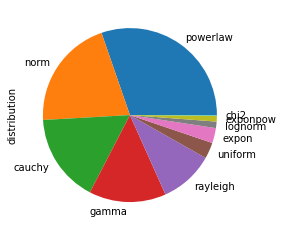

In [30]:
#I was going to plot this but they're all cauchy 
distribution_counts = best_fits['distribution'].value_counts()
distribution_counts.plot.pie()
print(distribution_counts)

<AxesSubplot:xlabel='loc', ylabel='scale'>

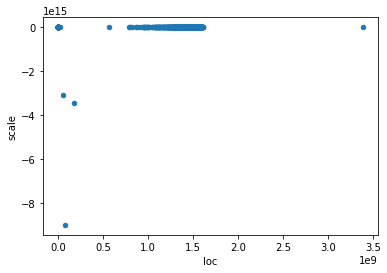

In [29]:
best_fits.plot.scatter(x = 'loc', y = 'scale')

,sumsquare_error,aic,bic,kl_div
powerlaw,5.470643e-17,4087.421566,-7.517789e+06,0.096127
norm,9.749688e-17,4129.231142,-7.429824e+06,0.137952
gamma,1.028244e-16,4133.601173,-7.421712e+06,0.145015
cauchy,1.142180e-16,4164.690002,-7.405725e+06,0.163849
uniform,1.701379e-16,4021.095014,-7.345053e+06,0.527257


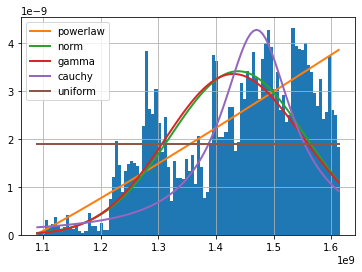

In [37]:
#example distribution
powerlaws = best_fits[best_fits['distribution'] == 'powerlaw']['project'].tolist()
plp = random.sample(powerlaws, 1)
plp = plp[0]
print(plp)
commits = df[df['projectID'] == plp]['committerTime'].to_numpy().astype(int)
data = commits
f = Fitter(data,
           distributions= get_common_distributions())
f.fit()
f.summary()

collective_plonetheme.earthlingtwo


,sumsquare_error,aic,bic,kl_div
norm,6.250225e-17,4673.350298,-9.038689e+07,inf
cauchy,8.373264e-17,4233.623576,-8.987550e+07,inf
rayleigh,1.803561e-16,inf,-8.853365e+07,inf
uniform,5.429380e-16,4041.449102,-8.660639e+07,inf
expon,6.207217e-16,4113.143048,-8.637225e+07,inf


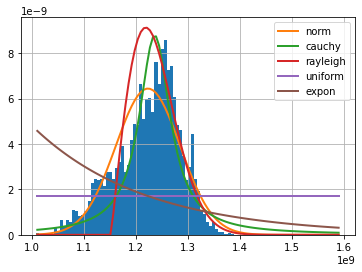

In [39]:
#example distribution
normals = best_fits[best_fits['distribution'] == 'norm']['project'].tolist()
np = random.sample(normals, 1)
np = np[0]
print(np)
commits = df[df['projectID'] == np]['committerTime'].to_numpy().astype(int)
data = commits
f = Fitter(data,
           distributions= get_common_distributions())
f.fit()
f.summary()

bitcoin_bitcoin


,sumsquare_error,aic,bic,kl_div
cauchy,3.052325e-17,4.751662e+03,-4.113755e+07,inf
norm,3.626282e-17,1.733807e+04,-4.100023e+07,inf
powerlaw,3.685588e-17,inf,-4.098728e+07,0.072970
rayleigh,1.042335e-16,inf,-4.015874e+07,0.380783
uniform,2.371472e-16,4.244591e+03,-3.950358e+07,inf


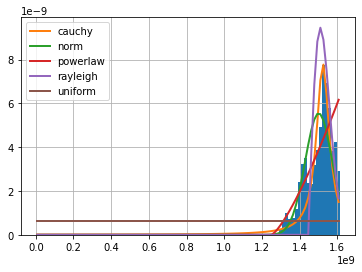

In [65]:
#example distribution
cauchys = best_fits[best_fits['distribution'] == 'cauchy']['project'].tolist()
cp = random.sample(cauchys, 1)
cp = cp[0]
print(cp)
commits = df[df['projectID'] == cp]['committerTime'].to_numpy().astype(int)
data = commits
f = Fitter(data,
           distributions= get_common_distributions())
f.fit()
f.summary()

In [66]:
pl_scale = best_fits[best_fits['distribution'] == 'powerlaw']['scale'].to_numpy()
norm_scale = best_fits[best_fits['distribution'] == 'norm']['scale'].to_numpy()
cau_scale = best_fits[best_fits['distribution'] == 'cauchy']['scale'].to_numpy()

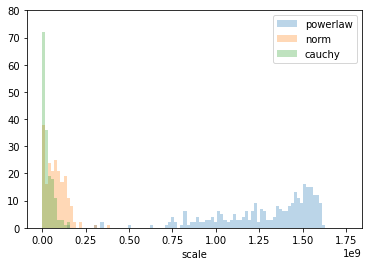

In [67]:
bins = numpy.linspace(0, 1750000000, 100)
plt.ylim(0,80)
plt.hist(pl_scale, bins, alpha=0.3, label='powerlaw')
plt.hist(norm_scale, bins, alpha=0.3, label='norm')
plt.hist(cau_scale, bins, alpha=0.3, label='cauchy')
plt.legend(loc='upper right')
plt.xlabel('scale')
plt.show()

In [68]:
def countauthors(dist):
    counts = []
    for proj in best_fits[best_fits['distribution'] == dist]['project'].tolist():
        print(proj)
        count = df[df['projectID'] == proj]['author']
        count = count.nunique()
        print(count)
        counts.append(count)
    return numpy.array(counts)

In [69]:
authorcounts = {}
for dist in get_common_distributions():
    print('--- ', dist, '---')
    authors = countauthors(dist)
    authorcounts[dict] = authors
    numpy.savetxt(dist + "authors.csv", authorcounts, delimiter=",")
    

---  cauchy ---
doctorjei_pidgin


KeyboardInterrupt: 

### [5.3] Develop static and interactive visualizations to demonstrate the findings.